In [58]:
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import os

In [59]:
### Parameters
batch_size = 64

In [60]:
class GZ2Dataset(Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        """
        Initializes the dataset.

        Parameters:
            csv_file_maps (str): Name of *.csv file that contains the filename to id mapping for the images
            csv_file_data (str): Name of *.csv file that contains the labeled data for every id
            root_dir (str): Directory containing all the images
            transform (class from torchvision.transforms): Transform to be used on the image data
        """
        self.maps = pd.read_csv(csv_file_maps)
        self.data = pd.read_csv(csv_file_data)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) -> int:
        """
        Returns the size of the dataset as number of elements.

        Returns:
            int: Number of elements
        """
        return len(self.data)
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        # Value of the "dr7objid" field for the current element
        dr7objid = self.data['dr7objid'][index]

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # pandas Dataframe containing all the datapoints for the given dr7objid
        image_data = self.data.loc[self.data['dr7objid'] == dr7objid]
        predictions = [image_data.to_numpy()[0][13], image_data.to_numpy()[0][19], image_data.to_numpy()[0][25]]
        prediction = predictions.index(max(predictions))

        # Possible predictions:
        # 0:= smooth
        # 1:= features
        # 2:= starshape

        if self.transform:
            image = self.transform(image)

        output = [image, prediction]

        return tuple(output)

In [61]:
transform = transforms.Compose([transforms.ToTensor()]) # Transforms to be used on the data

dataset = GZ2Dataset(csv_file_maps='gz2_filename_mapping.csv', csv_file_data='gz2_hart16.csv', root_dir='images_gz2/images/', transform=transform)

# Split dataset into training and testing data using 80% of the dataset for training and 20% for testing 
trainset, testset = random_split(dataset, [round(0.8*len(dataset)), round(0.2*len(dataset))])

In [62]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

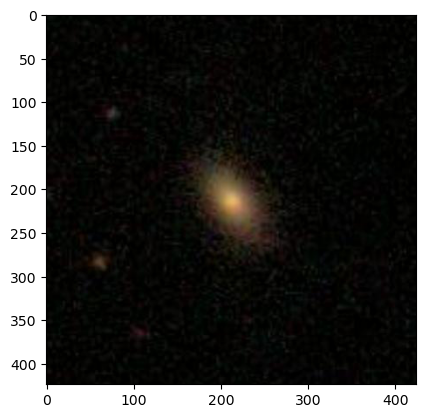

In [63]:
image, label = next(iter(trainloader))

plt.imshow(image[0].permute(1,2,0).numpy())

In [64]:
stuff = dataset.data